In [46]:
import os
from classesCHANGE import PointCloudFiltering, UnsupervisedSegmentationAlgorithm, PointCloudGenerator, CropAnalyzer
import time
import plyfile 
import open3d as o3d
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [47]:
# Instantiate classes
pcd_filtering = PointCloudFiltering()
unsup_segmentation = UnsupervisedSegmentationAlgorithm()
pcd_functions = PointCloudGenerator(r"C:/Users/Jay")


In [48]:
# pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Documents\Github\HarvestEye\Avocado100_30deg_group1_densified_point_cloud.ply')
pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Desktop\avoFixed.ply') #Avocado100_30deg_group1_densified_point_cloud.ply')
# pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Downloads\Avocado_s 100 30deg colorized.ply')

# o3d.visualization.draw_geometries([pcd])

In [49]:
# Downsample the point cloud
voxel_size = 0.25
downsampled_pcd = pcd_functions.downsamples_pointcloud(pcd, voxel_size)

# Normalize the point cloud
xyzrgb_normalized = pcd_functions.pcd_array_normalized(downsampled_pcd)

# Define weights and number of clusters for KMeans
weights = [5, 5, 500, 1, 550, 1]
num_clusters = 2
kmeans_labels, kmeans = unsup_segmentation.normalized_and_weighted_kmeans(weights, xyzrgb_normalized, num_clusters)

# Prepare cluster colors array
cluster_colors = np.zeros_like(xyzrgb_normalized[:, :3])  # Use only the XYZ part for colors

# Define colors for clusters
colors = {
    "green": [0, 150/255, 0],  # Green color
    "brown": [0.647, 0.165, 0.165]  # Brown color
}

# Identify the larger cluster
larger_cluster_label = np.argmax(np.bincount(kmeans_labels))

# Assign colors based on cluster sizes
for i in range(num_clusters):
    color = colors["brown"] if i == larger_cluster_label else colors["green"]
    cluster_colors[kmeans_labels == i] = color

seg_pcd = downsampled_pcd
seg_pcd.colors = o3d.utility.Vector3dVector(cluster_colors)
# o3d.visualization.draw_geometries([seg_pcd])

In [50]:
import importlib
import classesCHANGE
importlib.reload(classesCHANGE)

# Re-import the specific classes from the module
from classesCHANGE import PointCloudFiltering, UnsupervisedSegmentationAlgorithm, PointCloudGenerator, CropAnalyzer

# Now use the classes as needed
pcd_filtering = PointCloudFiltering()

ground_points = np.asarray(seg_pcd.points)[kmeans_labels == larger_cluster_label]
crop_points = np.asarray(seg_pcd.points)[kmeans_labels != larger_cluster_label]



In [51]:
def filter_points_by_grid(points, grid_resolution, std_limit, avg_z_filter_iteration_times):
    """
    Filters points in a point cloud based on a grid resolution and standard deviation limit.

    Parameters:
    - points: numpy array with xyz coordinates of the points.
    - grid_resolution: size of the grid cells.
    - std_limit: standard deviation limit for outlier detection.

    Returns:
    - Filtered points as a numpy array.
    """

    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
    z_min, z_max = np.min(points[:, 2]), np.max(points[:, 2])

    # Create the grid
    x_bins = np.arange(x_min, x_max, grid_resolution)
    y_bins = np.arange(y_min, y_max, grid_resolution)

    # Digitize points into grid cells
    x_indices = np.digitize(points[:, 0], x_bins)
    y_indices = np.digitize(points[:, 1], y_bins)

    # Calculate local averages and standard deviations for each grid cell
    local_averages = np.zeros((len(x_bins)-1, len(y_bins)-1))
    local_std_devs = np.zeros((len(x_bins)-1, len(y_bins)-1))

    for i in range(1, len(x_bins)):
        for j in range(1, len(y_bins)):
            mask = (x_indices == i) & (y_indices == j)
            points_in_cell = points[mask]
            if len(points_in_cell) > 0:
                local_averages[i-1, j-1] = np.mean(points_in_cell[:, 2])
                local_std_devs[i-1, j-1] = np.std(points_in_cell[:, 2])

    # Filter out points based on local averages and standard deviations
    thresholds = local_averages + std_limit * local_std_devs
    mask = np.zeros(len(points), dtype=bool)
    for _ in range(avg_z_filter_iteration_times):
        for i in range(1, len(x_bins)):
            for j in range(1, len(y_bins)):
                cell_mask = (x_indices == i) & (y_indices == j)
                if np.any(cell_mask):
                    mask |= (cell_mask) & (points[:, 2] < thresholds[i-1, j-1])
        filtered_points = points[mask]

    return filtered_points

def filter_ground_points(ground_points, avg_z_filter_interation_times, grid_resolution, std_limit):
    """
    Filters ground points based on the average z-value and a grid-based local filtering method.

    Parameters:
    - ground_points: numpy array with xyz coordinates of the ground points.
    - avg_z_filter_iteration_times: number of iterations for z-average filtering.
    - grid_resolution: size of the grid cells.
    - std_limit: standard deviation limit for outlier detection.

    Returns:
    - Filtered ground points as a numpy array.
    """
    # for _ in range(avg_z_filter_interation_times):
    #     z_average = np.mean(ground_points[:, 2])
    #     z_std = np.std(ground_points[:, 2])
    #     print("hello wrld 3", z_average, z_std)
    #     threshold = z_average + std_limit*z_std
    #     mask = ground_points[:, 2] < threshold # Remove points that are1 standard deviation or more away from the mean
    #     ground_points = ground_points[mask]

    # Use filtering by creating a grid and local averages to filter out ground points more, locally however
    filtered_ground_points = filter_points_by_grid(ground_points, grid_resolution, std_limit, avg_z_filter_interation_times)

    return filtered_ground_points   

In [52]:
x_min, x_max = np.min(ground_points[:, 0]), np.max(ground_points[:, 0])
x_range = x_max - x_min
grid_resolution = x_range / 2

# Filter the Ground Points list
#filtered_ground_points = pcd_filtering.filter_ground_points(ground_points, 3, grid_resolution, 0.15)
filtered_ground_points = pcd_filtering.filter_ground_points(ground_points, 1, 7, 0.001)
filtered_ground_pcd = o3d.geometry.PointCloud()
filtered_ground_pcd.points = o3d.utility.Vector3dVector(filtered_ground_points)
# o3d.visualization.draw_geometries([filtered_ground_pcd]) #+ [seg_pcd])

In [53]:
filtered_crop_points = pcd_filtering.filter_points_by_grid(crop_points, 0.75, 0.5, 5)
filtered_crop_pcd = o3d.geometry.PointCloud()
filtered_crop_pcd.points = o3d.utility.Vector3dVector(filtered_crop_points)
# o3d.visualization.draw_geometries([filtered_crop_pcd])

In [54]:
# Filter points based on DBSCAN clustering
eps = 0.28  # epsilon value for DBSCAN
dbscan_labels, clustered_points_xyz = unsup_segmentation.crop_clustering_dbscan(eps, filtered_crop_points)


import random
#Convert clustered_tree_points to an Open3D point cloud
dbscan_clusters_pcd = o3d.geometry.PointCloud()
dbscan_clusters_pcd.points = o3d.utility.Vector3dVector(clustered_points_xyz)

dbscan_clusters_filtered_points, filtered_labels = pcd_filtering.dbscan_cluster_filtering(dbscan_clusters_pcd, 20, 10000, dbscan_labels)
# Ensure dbscan_clusters_filtered_points is a PointCloud object
if isinstance(dbscan_clusters_filtered_points, o3d.geometry.PointCloud):
    # Assign random colors to each cluster
    cluster_colors = {}
    for label in np.unique(filtered_labels):
        if label == -1:  # Skip noise points
            continue
        color = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]  # Generate a random RGB color
        cluster_colors[label] = color

    # Assign colors to each point based on its cluster
    point_colors = []
    for label in filtered_labels:
        if label == -1:  # Noise points
            point_colors.append([0.5, 0.5, 0.5])  # Gray color
        else:
            point_colors.append(cluster_colors[label])

    # Set colors for the clustered tree points
    dbscan_clusters_filtered_points.colors = o3d.utility.Vector3dVector(point_colors)

    # Set the visualization mode to "unlit" for precise color rendering
#    o3d.visualization.draw_geometries([dbscan_clusters_filtered_points])
else:
    print(f"Expected dbscan_clusters_filtered_points to be a PointCloud, but got {type(dbscan_clusters_filtered_points)} instead.")

[ 0  1  2 ... 15 12 12]


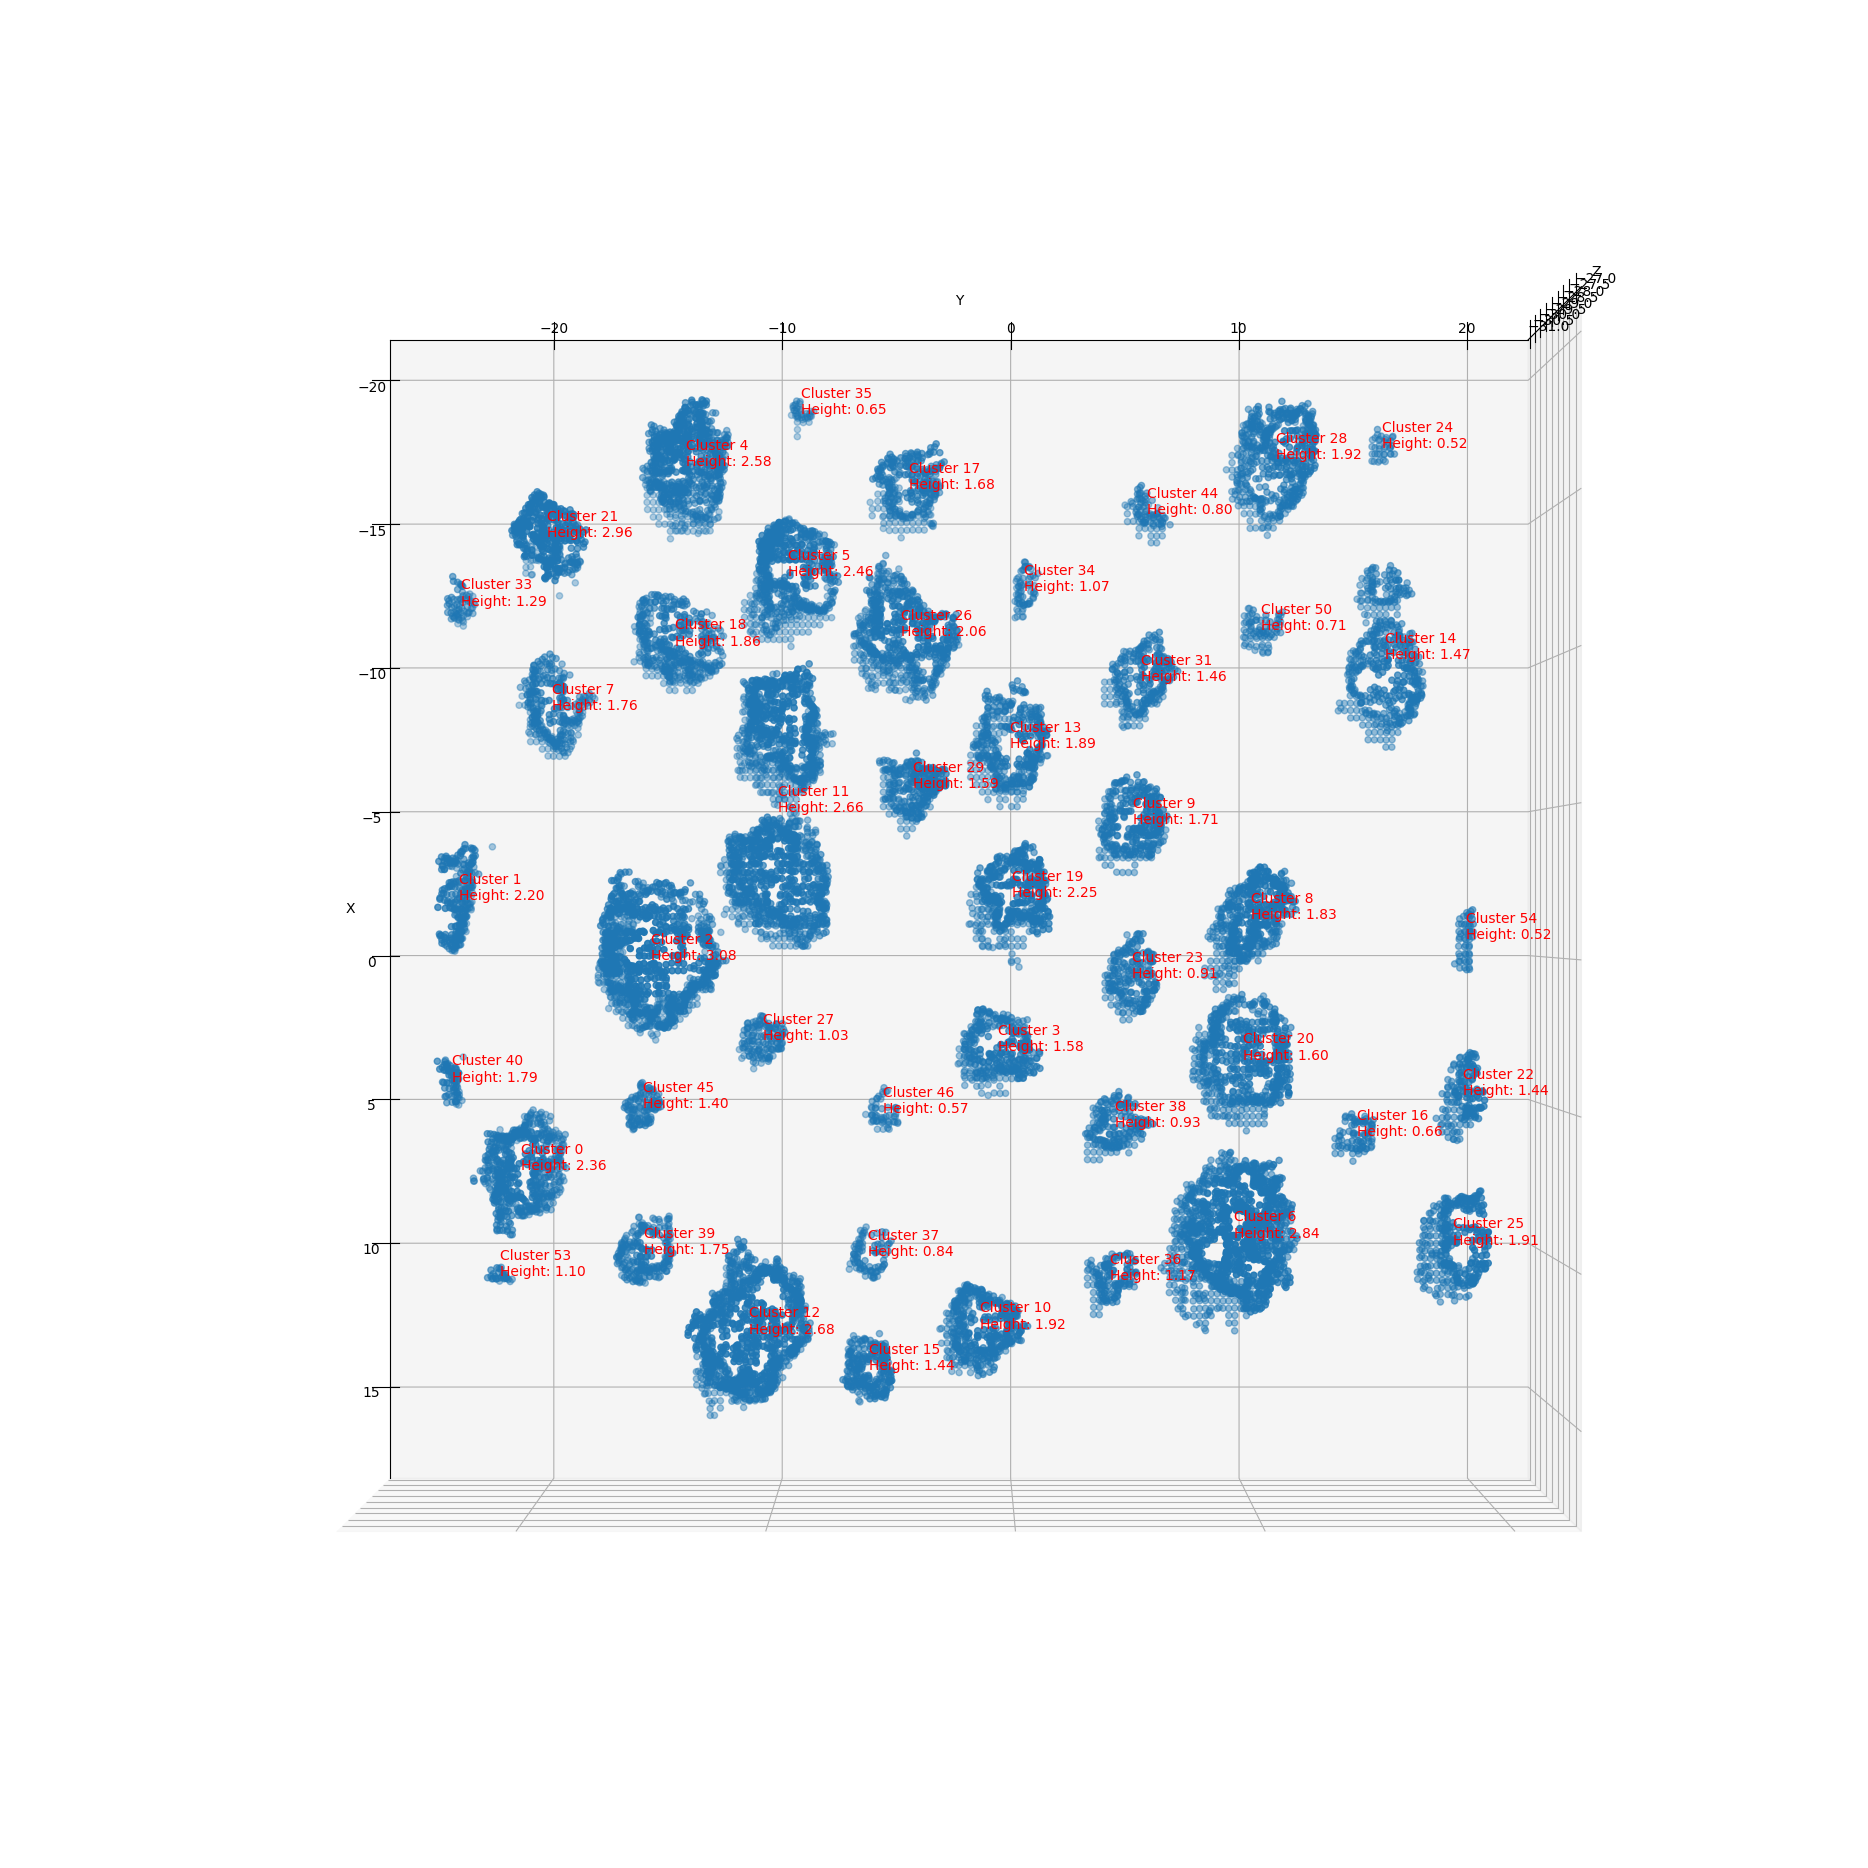

In [55]:
analyzer = CropAnalyzer()

heights, labels = analyzer.calculate_heights_and_labels(filtered_labels, dbscan_clusters_filtered_points, filtered_ground_pcd)

# Calculate cluster centers
cluster_centers = analyzer.calculate_cluster_centers(filtered_labels, np.asarray(dbscan_clusters_filtered_points.points))

# Visualize the heights and point cloud data
analyzer.visualize_the_heights_and_pcd(heights, dbscan_clusters_filtered_points, cluster_centers)

In [56]:
analyzer.visualize_height_gradient(dbscan_clusters_filtered_points, filtered_ground_pcd)


[Open3D WARNING] [SimpleShaderForLineSet] Binding failed with empty geometry::LineSet.
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed when preparing data.
[Open3D WARNING] [SimpleShaderForLineSet] Something is wrong in compiling or binding.
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed with empty geometry::LineSet.
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed when preparing data.
[Open3D WARNING] [SimpleShaderForLineSet] Something is wrong in compiling or binding.
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed with empty geometry::LineSet.
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed when preparing data.
[Open3D WARNING] [SimpleShaderForLineSet] Something is wrong in compiling or binding.
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed with empty geometry::LineSet.
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed when preparing data.
[Open3D WARNING] [SimpleShaderForLineSet] Something is wrong in compiling or bindi